In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt

11490434/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 56, 56, 3)
60000 train samples
10000 test samples


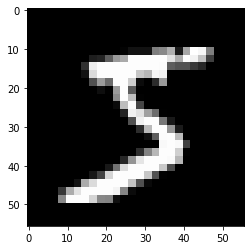

In [2]:
# Model / data parameters
num_classes = 10
input_shape = (56, 56, 3)

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# reshape to write input shape
x_train = np.array([cv2.cvtColor(cv2.resize(x, input_shape[:2], 
                                            interpolation = cv2.INTER_AREA),cv2.COLOR_GRAY2RGB) for x in x_train])
x_test = np.array([cv2.cvtColor(cv2.resize(x, input_shape[:2], 
                                           interpolation = cv2.INTER_AREA),cv2.COLOR_GRAY2RGB) for x in x_test])
# Make sure images have shape (28, 28, 1)
# x_train = np.expand_dims(x_train, -1)
# x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")
# preprocess input
plt.imshow(x_train[0])



# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [3]:
base_model = keras.applications.MobileNet(
    input_shape=input_shape,
    alpha=1.0,
    depth_multiplier=1,
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax"
)
base_model.trainable = False

In [8]:
def custom_augmentation(np_tensor):
 
  def random_crop(np_tensor):
 
    #cropped height between 70% to 130% of an original height
    new_height = int(np.random.uniform(0.7, 1.30) * np_tensor.shape[0])
 
    #cropped width between 70% to 130% of an original width
    new_width = int(np.random.uniform(0.7, 1.30) * np_tensor.shape[1])
 
    # resize to new height and width
    cropped = tf.image.resize_with_crop_or_pad(np_tensor, new_height, new_width)
 
    return tf.image.resize(cropped, np_tensor.shape[:2])
 
  augmnted_tensor = random_crop(np_tensor)
  return np.array(augmnted_tensor)

In [4]:
inputs = keras.Input(shape=input_shape)
# preprocess for mobile net
preprocessed_input = keras.applications.mobilenet_v2.preprocess_input(inputs)
base_outputs = base_model(preprocessed_input, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(base_outputs)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(num_classes,activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 56, 56, 3)]       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 56, 56, 3)        0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 56, 56, 3)        0         
 a)                                                              
                                                                 
 mobilenet_1.00_224 (Functio  (None, 1, 1, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                      

In [5]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train, batch_size=32, epochs=10, validation_split=0.1)

Epoch 1/10
1688/1688 [==============================] - 19s 9ms/step - loss: 2.2789 - accuracy: 0.1591 - val_loss: 2.2567 - val_accuracy: 0.1970
Epoch 2/10
1688/1688 [==============================] - 17s 10ms/step - loss: 2.2561 - accuracy: 0.1851 - val_loss: 2.2370 - val_accuracy: 0.1887
Epoch 3/10
1688/1688 [==============================] - 15s 9ms/step - loss: 2.2463 - accuracy: 0.1861 - val_loss: 2.2228 - val_accuracy: 0.2140
Epoch 4/10
1688/1688 [==============================] - 14s 9ms/step - loss: 2.2375 - accuracy: 0.1906 - val_loss: 2.2128 - val_accuracy: 0.2263
Epoch 5/10
1688/1688 [==============================] - 15s 9ms/step - loss: 2.2331 - accuracy: 0.1907 - val_loss: 2.2055 - val_accuracy: 0.2208
Epoch 6/10
1688/1688 [==============================] - 19s 12ms/step - loss: 2.2259 - accuracy: 0.1911 - val_loss: 2.1984 - val_accuracy: 0.2333
Epoch 7/10
1688/1688 [==============================] - 16s 10ms/step - loss: 2.2256 - accuracy: 0.1917 - val_loss: 2.1948 - val

In [6]:
base_model.trainable = True
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 56, 56, 3)]       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 56, 56, 3)        0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 56, 56, 3)        0         
 a)                                                              
                                                                 
 mobilenet_1.00_224 (Functio  (None, 1, 1, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                      

In [7]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss="categorical_crossentropy", metrics=["accuracy"]
)

epochs = 10
model.fit(x_train, y_train, batch_size=32, epochs=epochs, validation_split=0.1)

Epoch 1/10
1688/1688 [==============================] - 35s 19ms/step - loss: 1.8992 - accuracy: 0.2821 - val_loss: 1.4431 - val_accuracy: 0.5318
Epoch 2/10
1688/1688 [==============================] - 30s 18ms/step - loss: 0.9985 - accuracy: 0.7216 - val_loss: 0.2560 - val_accuracy: 0.9548
Epoch 3/10
1688/1688 [==============================] - 31s 18ms/step - loss: 0.2490 - accuracy: 0.9387 - val_loss: 0.1165 - val_accuracy: 0.9673
Epoch 4/10
1688/1688 [==============================] - 29s 17ms/step - loss: 0.1561 - accuracy: 0.9570 - val_loss: 0.1158 - val_accuracy: 0.9658
Epoch 5/10
1688/1688 [==============================] - 32s 19ms/step - loss: 0.1281 - accuracy: 0.9637 - val_loss: 0.0956 - val_accuracy: 0.9720
Epoch 6/10
1688/1688 [==============================] - 30s 18ms/step - loss: 0.1129 - accuracy: 0.9672 - val_loss: 0.0609 - val_accuracy: 0.9817
Epoch 7/10
1688/1688 [==============================] - 30s 18ms/step - loss: 0.1051 - accuracy: 0.9694 - val_loss: 0.0475 -

In [8]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.05108360946178436
Test accuracy: 0.9832000136375427


313/313 [==============================] - 2s 5ms/step


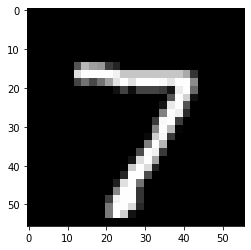

In [12]:
plt.imshow(x_test[0])
predictions = model.predict([x_test])


In [15]:
print(predictions[0])
print(y_test[0])

[1.2437278e-06 7.5630282e-06 7.9193969e-06 6.7010092e-06 7.1489285e-07
 8.7174121e-06 1.5081440e-07 9.9996316e-01 5.2361520e-07 3.3015920e-06]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
